In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd

In [3]:
# given point

In [4]:
# # read in tile_points.csv
# points = pd.read_csv('../../data/tile_points.csv')

# row = points.iloc[10000]

In [5]:
# find enclosing tile

In [6]:
import geopandas as gpd

In [7]:
from nbhd.data import Base

Initializing database connection...
Database connected!


In [8]:
db = Base()

In [9]:
from nbhd.geography import Neighbourhood

In [10]:
n = Neighbourhood(load=False)#row.x, row.y, 

In [11]:
# nearest roads ~ 'slimroads' is without motorways and secondary roads

In [12]:
nr_roads = n.db.nearest_neighbours('slimroads', n.geom.buffer(10))

In [13]:
# nearest buildings

In [14]:
nr_buildings = n.db.nearest_neighbours('openmaplocal', n.geom.buffer(1))

In [15]:
# merge on UPRN

In [16]:
df = nr_buildings.merge(nr_roads, on=['UPRN', 'uprn_geometry'], how='inner', suffixes=('_building', '_street'))

In [17]:
del(nr_buildings)
del(nr_roads)

In [18]:
# 1 eliminate non-building properties : distance to building must == 0

In [19]:
df1 = df.loc[df.dist_building==0]

In [20]:
# 2 eliminate non-residential buildings : area / uprn count must < 250

In [21]:
building_counts = dict(df1.id_building.value_counts())

In [22]:
df1['building_counts'] = df1.id_building.apply(lambda x: building_counts.get(x, 0))

<ipython-input-22-909eb256e9a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['building_counts'] = df1.id_building.apply(lambda x: building_counts.get(x, 0))


In [23]:
df1['footprint_area'] = gpd.GeoSeries(df1.geometry_building).area
df1['footprint_area_per_uprn'] = df1.footprint_area / df1.building_counts

<ipython-input-23-5ba437b08873>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['footprint_area'] = gpd.GeoSeries(df1.geometry_building).area
<ipython-input-23-5ba437b08873>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['footprint_area_per_uprn'] = df1.footprint_area / df1.building_counts


In [24]:
df1['residential_building'] = df1['footprint_area_per_uprn'] < 250

<ipython-input-24-dd708221cae7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['residential_building'] = df1['footprint_area_per_uprn'] < 250


In [25]:
df2 = df1.loc[df1.residential_building]

In [26]:
# 3 establish whether roads are residential : length / uprn count must < 5??

In [27]:
street_counts = dict(df2.id_street.value_counts())

In [28]:
df2['street_counts'] = df2.id_street.apply(lambda x: street_counts.get(x, 0))

<ipython-input-28-be680ec1f918>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['street_counts'] = df2.id_street.apply(lambda x: street_counts.get(x, 0))


In [29]:
df2['street_length_per_uprn'] = df2.length / df2.street_counts

<ipython-input-29-0dd6277d304b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['street_length_per_uprn'] = df2.length / df2.street_counts


In [30]:
df2['residential_street'] = df2.street_length_per_uprn < 20

<ipython-input-30-3528602d91a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['residential_street'] = df2.street_length_per_uprn < 20


In [31]:
residential = dict(zip(df2.id_street, df2.residential_street))

In [32]:
df['residential'] = df.id_street.apply(lambda x: residential.get(x, False))

In [33]:
df['short_street'] = df.length < 100

In [34]:
df['res_or_short'] = df.residential | df.short_street

In [35]:
df3 = df.loc[df.res_or_short]

In [36]:
# 4 find connected networks of residential streets

In [37]:
streets3 = df3[['id_street', 'startNode', 'endNode', 'length', 'roadFunction', 'geometry_street']]

In [38]:
streets = df[['id_street', 'startNode', 'endNode', 'length', 'roadFunction', 'geometry_street']]

In [39]:
streets_gdf3 = gpd.GeoDataFrame(df3, geometry='geometry_street')

In [40]:
streets_gdf = gpd.GeoDataFrame(df, geometry='geometry_street')

<AxesSubplot:>

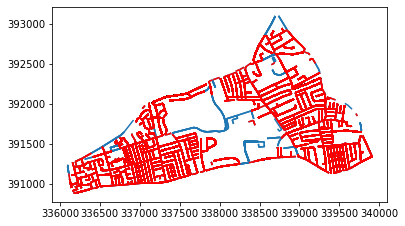

In [41]:
t = streets_gdf.plot()
streets_gdf3.plot(color='red', ax=t.axes)

In [42]:
import networkx as nx

In [43]:
edges = streets3.loc[~streets3.duplicated()]

In [44]:
edges

,id_street,startNode,endNode,length,roadFunction,geometry_street
0,id5E137843-85D8-4E11-AFC6-4714A213B5D3,id136C88AB-84CB-4844-B3EA-250D06F589BF,id1196BE64-808A-4DBE-B12F-606B6135E0F0,66,Local Road,"LINESTRING (339491.000 391787.000, 339491.000 ..."
8,id24A5A4B8-EF6C-40AD-AB7C-AB0B64A6510A,id54779C1B-8693-4A80-816F-BAFBF95E89C1,id1196BE64-808A-4DBE-B12F-606B6135E0F0,103,Local Road,"LINESTRING (339536.000 391780.000, 339535.080 ..."
24,idC91AED0D-B5BE-457D-827E-63BC083CB177,id3E853882-05E4-4B04-A3DA-D1790327D7AE,idAE5D8D95-077B-4856-B195-6A6516A17A6E,56,Local Road,"LINESTRING (339614.000 391264.000, 339638.500 ..."
25,id4C57AD07-7552-4200-9934-F6783A58AEED,idAE5D8D95-077B-4856-B195-6A6516A17A6E,idC9C1B900-F386-47D8-AC66-178BA124749F,239,Local Road,"LINESTRING (339663.000 391291.000, 339709.000 ..."
26,id116291A0-C738-4161-B2CA-162C291D4C9F,idAE5D8D95-077B-4856-B195-6A6516A17A6E,id23881A15-3638-4DAA-A6EF-A36D9F3E84D6,207,Local Road,"LINESTRING (339663.000 391291.000, 339647.000 ..."
...,...,...,...,...,...,...
14808,id47AF93F2-9F70-4FC0-9FF6-AA4D325FDED0,id2F3DD07C-1026-4C4E-A354-1A9791AF0E2B,id8E7D0DE8-571F-4E47-ABC9-FE12FE13706F,29,Local Road,"LINESTRING (339282.000 391784.000, 339282.000 ..."
14837,id733ECEDD-6428-4DE6-B6CC-257FEAAA4A03,idBC0A1FD5-81AD-464B-AC1F-9CD21FE6E36B,id01944055-29FF-4B14-8C88-E7C8B55EC694,24,Local Road,"LINESTRING (339301.620 391935.000, 339313.810 ..."
14840,id0D4203DA-2130-4D66-B65E-88EDAE91826E,id01944055-29FF-4B14-8C88-E7C8B55EC694,id3F77B8EF-8DDE-42E4-991B-C36D143C6758,46,Minor Road,"LINESTRING (339326.000 391935.000, 339325.000 ..."
15106,id7EC4BF87-BD72-4DA2-965C-1BAB0ABA346F,idC9C1B900-F386-47D8-AC66-178BA124749F,id235942AE-30F3-4BFF-8D48-D48261B35762,33,Local Road,"LINESTRING (339684.000 391501.000, 339700.500 ..."


In [55]:
edges['translated_start'] = 

,id_street,startNode,endNode,length,roadFunction,geometry_street,community
0,id5E137843-85D8-4E11-AFC6-4714A213B5D3,id136C88AB-84CB-4844-B3EA-250D06F589BF,id1196BE64-808A-4DBE-B12F-606B6135E0F0,66,Local Road,"LINESTRING (339491.000 391787.000, 339491.000 ...",00
8,id24A5A4B8-EF6C-40AD-AB7C-AB0B64A6510A,id54779C1B-8693-4A80-816F-BAFBF95E89C1,id1196BE64-808A-4DBE-B12F-606B6135E0F0,103,Local Road,"LINESTRING (339536.000 391780.000, 339535.080 ...",00
24,idC91AED0D-B5BE-457D-827E-63BC083CB177,id3E853882-05E4-4B04-A3DA-D1790327D7AE,idAE5D8D95-077B-4856-B195-6A6516A17A6E,56,Local Road,"LINESTRING (339614.000 391264.000, 339638.500 ...",01
25,id4C57AD07-7552-4200-9934-F6783A58AEED,idAE5D8D95-077B-4856-B195-6A6516A17A6E,idC9C1B900-F386-47D8-AC66-178BA124749F,239,Local Road,"LINESTRING (339663.000 391291.000, 339709.000 ...",01
26,id116291A0-C738-4161-B2CA-162C291D4C9F,idAE5D8D95-077B-4856-B195-6A6516A17A6E,id23881A15-3638-4DAA-A6EF-A36D9F3E84D6,207,Local Road,"LINESTRING (339663.000 391291.000, 339647.000 ...",01
...,...,...,...,...,...,...,...
14740,id8A91279C-2633-4705-9A92-9EBEAD559A5F,id075675CE-60CD-4284-9D73-5A34C40801AB,id025AFA2C-5A80-4E79-959B-004C35BC8E79,51,Local Road,"LINESTRING (339395.000 391801.000, 339420.500 ...",00
14851,id733ECEDD-6428-4DE6-B6CC-257FEAAA4A03,idBC0A1FD5-81AD-464B-AC1F-9CD21FE6E36B,id01944055-29FF-4B14-8C88-E7C8B55EC694,24,Local Road,"LINESTRING (339301.620 391935.000, 339313.810 ...",00
14854,id0D4203DA-2130-4D66-B65E-88EDAE91826E,id01944055-29FF-4B14-8C88-E7C8B55EC694,id3F77B8EF-8DDE-42E4-991B-C36D143C6758,46,Minor Road,"LINESTRING (339326.000 391935.000, 339325.000 ...",00
15049,id7EC4BF87-BD72-4DA2-965C-1BAB0ABA346F,idC9C1B900-F386-47D8-AC66-178BA124749F,id235942AE-30F3-4BFF-8D48-D48261B35762,33,Local Road,"LINESTRING (339684.000 391501.000, 339700.500 ...",01


In [44]:
g = nx.from_pandas_edgelist(edges, 'startNode', 'endNode', True)

In [45]:
subgraphs =[g.subgraph(c) for c in nx.connected_components(g)]

In [46]:
sgs = [sg for sg in subgraphs if len(sg) > 10]

In [47]:
communities = dict()
for i in range(len(sgs)):
    communities[str(i).zfill(2)] = list(nx.get_edge_attributes(sgs[i], 'id_street').values())

In [48]:
communities_key = {value:key for key, value_list in communities.items() for value in value_list}

In [49]:
edges['community'] = edges.id_street.apply(lambda x: communities_key.get(x, None))

<ipython-input-49-2e7a5e2ba858>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['community'] = edges.id_street.apply(lambda x: communities_key.get(x, None))


In [50]:
import matplotlib.pyplot as plt

In [51]:
rcParams = plt.matplotlib.rcParams
def get_prop_cycle():
    prop_cycler = rcParams['axes.prop_cycle']
    if prop_cycler is None and 'axes.color_cycle' in rcParams:
        clist = rcParams['axes.color_cycle']
        prop_cycler = cycler('color', clist)
    return prop_cycler

In [52]:
colors = [item['color'] for item in get_prop_cycle()]

<AxesSubplot:>

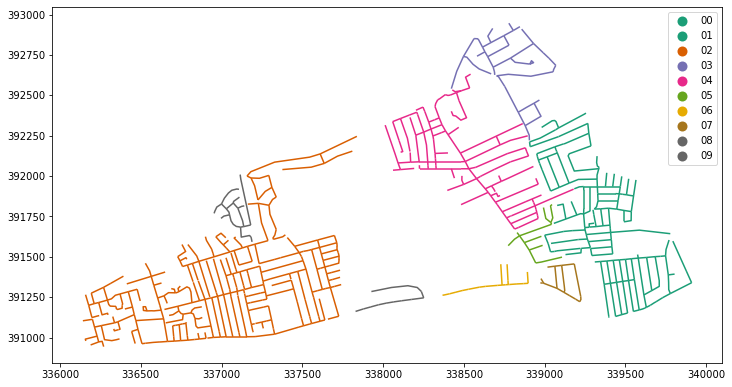

In [53]:
f, ax = plt.subplots(figsize=(12,12))
ax.set_prop_cycle(color=colors*100)

gpd.GeoDataFrame(edges, geometry='geometry_street').plot('community', cmap='Dark2', figsize=(12,12), legend=True, ax=ax)

In [54]:
# 5 find connected networks of residential and non-(B Road/ Minor Road) streets